# DDIM Inversion

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda:1"
else:
    device = "cpu"
print(device)

cuda:1


In [2]:
import torch
import PIL.Image as Image
from tqdm import tqdm
from torchvision import transforms
from diffusers.utils import load_image, make_image_grid
from diffusers import StableDiffusionPipeline, DDIMScheduler

2024-11-15 17:37:33.122199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 17:37:33.122251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 17:37:33.124038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 17:37:33.133265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 17:37:34.811032: W tensorflow/compiler/tf2

## load an image

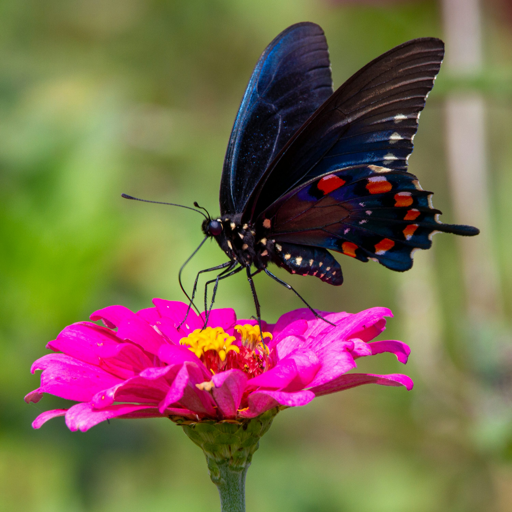

In [ ]:
# load a random image online

# resize the image to (512, 512)
# Any other squared size may work as well, but it should be a 8-multiply

url = "https://images.unsplash.com/photo-1623635241597-f9bf06ed282a?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NXx8emlubmlhfGVufDB8fDB8fHww"
ref_image = load_image(url).resize((512, 512))
ref_image

In [ ]:
# scale the image between -1 and 1

input_image = transforms.ToTensor()(ref_image).unsqueeze(0) * 2 - 1
input_image.shape

torch.Size([1, 3, 512, 512])

In [ ]:
# take a prompt best describe the input image.

prompt = "image butterfly on a pink flower in forest"

## Encode

In [ ]:
# load SD pipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
# encode

with torch.no_grad():
    input_latent = pipe.vae.encode(input_image.to(pipe.device)).latent_dist.sample() * 0.18215

print(input_latent.shape)
    

torch.Size([1, 4, 64, 64])


## inversion

From the DDIM paper, the latent depends on the original image and the the direction poiting to the latent at step t:

$$ x_{t-1} = \sqrt{\alpha_{t-1}} (\frac{x(t) - \sqrt{1-\alpha_t} \epsilon_{\theta}^t(x_t)}{\sqrt{\alpha_t}}) + \sqrt{1-\alpha_{t-1}-\sigma_{t}^2} \cdot \epsilon_{\theta}^t (x_t) + \sigma_t \epsilon_t$$

By inverting this equation, we can get the latent at step t:

$$x_t = (x_{t-1} - \sqrt{1-\alpha_{t-1}-\sigma_{t}^2} \cdot \epsilon_{\theta}^t (x_t)) \cdot \frac{\sqrt{\alpha_t}}{\sqrt{\alpha_{t-1}}} + \sqrt{1-\alpha_t} \epsilon_{\theta}^t(x_t)$$

Considering $\sigma_{t} = 0$.

In [29]:
print(f"the time steps: {timesteps}")

the time steps: tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 961, 981], device='cuda:1')


In [44]:
pipe.scheduler.timesteps

tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1], device='cuda:1')

In [34]:
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

In [36]:
pipe.scheduler.alphas_cumprod.shape

torch.Size([1000])

In [115]:
num_inference_steps = 50
guidance_scale = 3.5

pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = reversed(pipe.scheduler.timesteps)
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, '')

latents = input_latent.clone()
intermediate_latents = []

for i in tqdm(range(1, num_inference_steps)):

    # skip the final iteration
    if i >= num_inference_steps - 1: continue

    t = timesteps[i]
    t_next = timesteps[i+1]

    # Expand latents for cfg
    latent_model_input = torch.cat([latents] * 2)

    # scale lentent to the timestep t
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform cfg
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # get alpha values for t and t+1, spcaed by 1000//num_inference_steps
    alpha_t = pipe.scheduler.alphas_cumprod[t]
    alpha_t_next = pipe.scheduler.alphas_cumprod[t_next]

    # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
    dir_xt = (1-alpha_t).sqrt()*noise_pred
    mean_scale = alpha_t_next.sqrt()/alpha_t.sqrt()
    latents = (latents - dir_xt)*(mean_scale) + (1-alpha_t_next).sqrt()*noise_pred

    # Store
    intermediate_latents.append(latents)

inverted_latents = torch.cat(intermediate_latents)       

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:05<00:00,  8.61it/s]


In [60]:
print(inverted_latents.shape)

torch.Size([98, 4, 64, 64])


## Generate

In [ ]:
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None, num_inference_steps=30, device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(prompt, device, 1, True, '')

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # Expand the latents for cfg
        latent_model_input = torch.cat([latents] * 2) 
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Pdo cfg
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # update step
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # decode latent
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.45it/s]


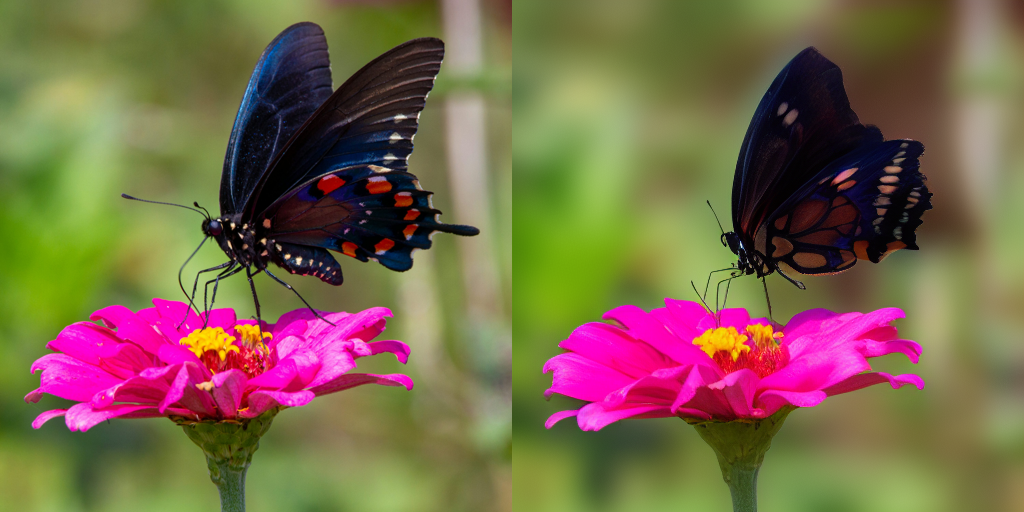

In [120]:
start_step = 15

# we make sure that we get the same image as the reference image
# the higher the number of start step, the more the reconstructed image resembles to the reference image.
# But if the number is too close to the number of the inference steps, it looses the capacity to generate images according to the prompt.

inversion_image = sample(prompt, start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, num_inference_steps=num_inference_steps)[0]

make_image_grid([ref_image, inversion_image], rows=1, cols=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.46it/s]


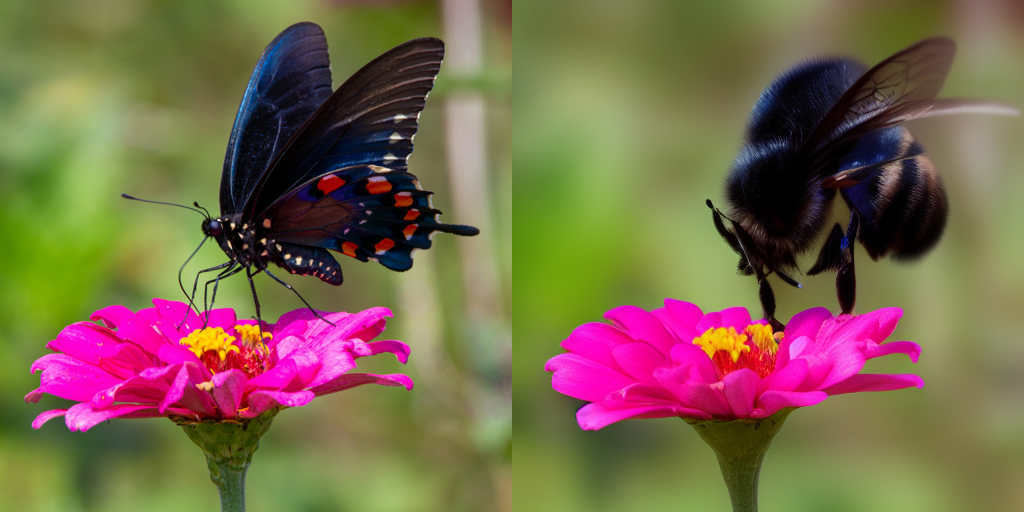

In [121]:
# Sampling with a new prompt

new_prompt = prompt.replace('butterfly', 'bee')
prompt_image = sample(new_prompt, start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, num_inference_steps=num_inference_steps)[0]

make_image_grid([ref_image, prompt_image], rows=1, cols=2)

Notes:
 - the bigger the num_inference_steps, the more details we will get for the reconstructed images.
 - We have to find the value of the start steps to get the desired result.
 - It doesn't work well when the replaced object is very different from the reference image.

The pros are:
 - No training is needed.
 - Inference is fast since using DDIM.